<a href="https://colab.research.google.com/github/Therodrogo/Tarea-U1-Taller-de-integracion/blob/main/Tareas_2_Taller_de_integracion_de_ciencias_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MHEALTH: descarga, carga, exploración y preprocesamiento


#  Tarea U1: Producto Computacional

**Nombre:** Rodrigo López

**Carrera:** Ingeniería Civil en Computación  
**Modulo:** Taller de integración de ciencias de datos

## Descarga y extración del dataset

In [2]:

import os
import re
import io
import zipfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler

DATA_DIR = Path("mhealth")
DATA_DIR.mkdir(exist_ok=True, parents=True)

zip_bytes = None
last_error = None

url=  "https://archive.ics.uci.edu/static/public/319/mhealth+dataset.zip"

try:
    print(f"Descargando desde: {url}")
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    zip_bytes = r.content
    print("Descarga OK.")
except Exception as e:
    print(f"Fallo con {url}: {e}")
    last_error = e

if zip_bytes is None:
    raise RuntimeError(f"No se pudo descargar el ZIP desde UCI. Último error: {last_error}")

# Extraer
with zipfile.ZipFile(io.BytesIO(zip_bytes)) as zf:
    zf.extractall(DATA_DIR)
print(f"Archivos extraídos en: {DATA_DIR.resolve()}")

Descargando desde: https://archive.ics.uci.edu/static/public/319/mhealth+dataset.zip
Descarga OK.
Archivos extraídos en: /content/mhealth


## Se verifica que se hayan descargado correctamente

In [3]:
log_files = sorted([p for p in DATA_DIR.rglob("*") if re.search(r"mHealth_subject\d+\.log$", p.name, re.I)])

if not log_files:
    raise RuntimeError(
        "No se encontraron archivos 'mHealth_subject*.log' tras extraer el ZIP. "
        "Revisa el contenido de la carpeta 'mhealth/'."
    )

print(f"Archivos de sujetos encontrados: {len(log_files)}")
for p in log_files[:5]:
    print(" -", p)

Archivos de sujetos encontrados: 10
 - mhealth/MHEALTHDATASET/mHealth_subject1.log
 - mhealth/MHEALTHDATASET/mHealth_subject10.log
 - mhealth/MHEALTHDATASET/mHealth_subject2.log
 - mhealth/MHEALTHDATASET/mHealth_subject3.log
 - mhealth/MHEALTHDATASET/mHealth_subject4.log


## Definición de columnas del dataset MHEALTH

A partir del archivo `README.txt`, se definen las 24 columnas del dataset.  
En la siguiente tabla se muestra la abreviación utilizada y su descripción:

| Nº Columna | Abreviación   | Descripción |
|------------|--------------|-------------|
| 1          | acc_chest_x  | Aceleración desde el sensor del pecho (eje X) |
| 2          | acc_chest_y  | Aceleración desde el sensor del pecho (eje Y) |
| 3          | acc_chest_z  | Aceleración desde el sensor del pecho (eje Z) |
| 4          | ecg_1        | Señal de electrocardiograma (lead 1) |
| 5          | ecg_2        | Señal de electrocardiograma (lead 2) |
| 6          | acc_ankle_x  | Aceleración desde el sensor del tobillo izquierdo (eje X) |
| 7          | acc_ankle_y  | Aceleración desde el sensor del tobillo izquierdo (eje Y) |
| 8          | acc_ankle_z  | Aceleración desde el sensor del tobillo izquierdo (eje Z) |
| 9          | gyro_ankle_x | Giroscopio desde el sensor del tobillo izquierdo (eje X) |
| 10         | gyro_ankle_y | Giroscopio desde el sensor del tobillo izquierdo (eje Y) |
| 11         | gyro_ankle_z | Giroscopio desde el sensor del tobillo izquierdo (eje Z) |
| 12         | mag_ankle_x  | Magnetómetro desde el sensor del tobillo izquierdo (eje X) |
| 13         | mag_ankle_y  | Magnetómetro desde el sensor del tobillo izquierdo (eje Y) |
| 14         | mag_ankle_z  | Magnetómetro desde el sensor del tobillo izquierdo (eje Z) |
| 15         | acc_arm_x    | Aceleración desde el sensor del brazo derecho (eje X) |
| 16         | acc_arm_y    | Aceleración desde el sensor del brazo derecho (eje Y) |
| 17         | acc_arm_z    | Aceleración desde el sensor del brazo derecho (eje Z) |
| 18         | gyro_arm_x   | Giroscopio desde el sensor del brazo derecho (eje X) |
| 19         | gyro_arm_y   | Giroscopio desde el sensor del brazo derecho (eje Y) |
| 20         | gyro_arm_z   | Giroscopio desde el sensor del brazo derecho (eje Z) |
| 21         | mag_arm_x    | Magnetómetro desde el sensor del brazo derecho (eje X) |
| 22         | mag_arm_y    | Magnetómetro desde el sensor del brazo derecho (eje Y) |
| 23         | mag_arm_z    | Magnetómetro desde el sensor del brazo derecho (eje Z) |
| 24         | label        | Etiqueta de actividad (0 corresponde a la clase nula) |


In [4]:
columns = [
    "acc_chest_x", "acc_chest_y", "acc_chest_z",
    "ecg_1", "ecg_2",
    "acc_ankle_x", "acc_ankle_y", "acc_ankle_z",
    "gyro_ankle_x", "gyro_ankle_y", "gyro_ankle_z",
    "mag_ankle_x", "mag_ankle_y", "mag_ankle_z",
    "acc_arm_x", "acc_arm_y", "acc_arm_z",
    "gyro_arm_x", "gyro_arm_y", "gyro_arm_z",
    "mag_arm_x", "mag_arm_y", "mag_arm_z",
    "label"
]

#Cargar todos los sujetos y concatenar

dfs = []
for fp in log_files:

    # subject_id desde el nombre del archivo
    m = re.search(r"subject(\d+)", fp.name, re.I)  #Usa expresiones regulares para buscar un número en el nombre del archivo
    subject_id = int(m.group(1)) if m else -1

    #Los .log no traen nombres de columnas, solo valores.
    #Los valores están separados por espacios (no por coma, por eso se usa sep=r"\s+").
    #header=None → para que pandas no use la primera fila como nombre de columna.
    df_subj = pd.read_csv(
        fp,
        sep=r"\s+",
        header=None,
        engine="python"
    )

    # Validación de columnas esperadas
    if df_subj.shape[1] != 24:
        raise ValueError(f"{fp.name} tiene {df_subj.shape[1]} columnas; se esperaban 24.")

    #Ahora cada columna tiene un nombre significativo.
    #Se agrega una columna extra "subject_id" para saber a qué persona corresponde cada fila.
    df_subj.columns = columns
    df_subj["subject_id"] = subject_id

    #Guardamos los datos de este sujeto en la lista general dfs
    dfs.append(df_subj)

#Unimos todos los df_subj en un solo DataFrame gigante.
#ignore_index=True reinicia los índices (para que no queden duplicados).
df = pd.concat(dfs, ignore_index=True)
print("\n=== Dimensiones del DataFrame completo ===")
print(df.shape)



=== Dimensiones del DataFrame completo ===
(1215745, 25)


Exploracion de datos

## Exploración inicial de los datos

### 1. Tipos de datos
Se revisan los tipos de datos de cada columna para verificar que las señales estén en formato numérico (`float` o `int`) y que la columna de etiquetas (`label`) tenga un tipo adecuado. Esto es importante porque, si alguna columna está mal cargada (por ejemplo como `object`), podría dar problemas en el análisis.

### 2. Valores faltantes
Se cuentan los valores faltantes (`NaN`) por columna, ordenados de mayor a menor.  
Este paso nos ayuda a identificar si existen columnas con problemas de calidad de datos que requieren imputar, eliminación o tratamiento especial.

### 3. Estadísticas descriptivas
Se calculan medidas estadísticas básicas (media, desviación estándar, mínimo, máximo, percentiles) de las variables numéricas.  
Con esto podemos:
- Identificar escalas diferentes entre sensores.
- Detectar posibles valores atípicos (por ejemplo, lecturas de sensores fuera de rango esperado).
- Ver la dispersión de los datos.

### 4. Distribución de etiquetas
Se cuenta cuántos registros tiene cada etiqueta de actividad (`label`).  
Esto permite analizar si el dataset está balanceado o si hay actividades con muchas más observaciones que otras, lo cual es importante para un futuro modelo de clasificación.

### 5. Visualizaciones iniciales
- **Histograma de `acc_chest_x`**: Permite observar la distribución de valores de una señal de acelerómetro ubicada en el pecho, identificando posibles asimetrías o valores atipicos.  
- **Gráfico de barras de la distribución de clases (`label`)**: Muestra de manera visual la cantidad de registros por cada clase, lo que complementa el análisis numérico previo de balance de clases.

Estas visualizaciones ayudan a tener una primera intuición sobre la calidad y características del dataset.

## 6. Evolución de la aceleración del sensor del pecho

En esta visualización se representa la **evolución temporal de la aceleración** medida por el sensor ubicado en el pecho del sujeto.  

- Cada línea corresponde a uno de los tres ejes de aceleración:
  - **X (acc_chest_x):** aceleración en el eje horizontal.
  - **Y (acc_chest_y):** aceleración en el eje vertical.
  - **Z (acc_chest_z):** aceleración en el eje perpendicular al pecho.
  
- El **eje X del gráfico** representa las **muestras** registradas a lo largo del tiempo (cada fila del dataset corresponde a un instante de muestreo).  
- El **eje Y del gráfico** muestra la **aceleración en metros por segundo al cuadrado (m/s²)**.  

Este gráfico permite:
- Observar cómo cambia la aceleración del pecho mientras se realizan diferentes actividades.  
- Detectar picos o movimientos bruscos, que pueden corresponder a cambios de postura o actividad física intensa.  
- Analizar patrones específicos de cada eje que pueden ser útiles para **reconocimiento de actividades**.



=== Tipos de datos ===
acc_chest_x     float64
acc_chest_y     float64
acc_chest_z     float64
ecg_1           float64
ecg_2           float64
acc_ankle_x     float64
acc_ankle_y     float64
acc_ankle_z     float64
gyro_ankle_x    float64
gyro_ankle_y    float64
gyro_ankle_z    float64
mag_ankle_x     float64
mag_ankle_y     float64
mag_ankle_z     float64
acc_arm_x       float64
acc_arm_y       float64
acc_arm_z       float64
gyro_arm_x      float64
gyro_arm_y      float64
gyro_arm_z      float64
mag_arm_x       float64
mag_arm_y       float64
mag_arm_z       float64
label             int64
subject_id        int64
dtype: object

=== Valores faltantes (top 10) ===
acc_chest_x     0
acc_chest_y     0
acc_chest_z     0
ecg_1           0
ecg_2           0
acc_ankle_x     0
acc_ankle_y     0
acc_ankle_z     0
gyro_ankle_x    0
gyro_ankle_y    0
dtype: int64

=== Estadísticas descriptivas (primeras columnas) ===
                  count      mean       std      min       25%       50%  \
ac

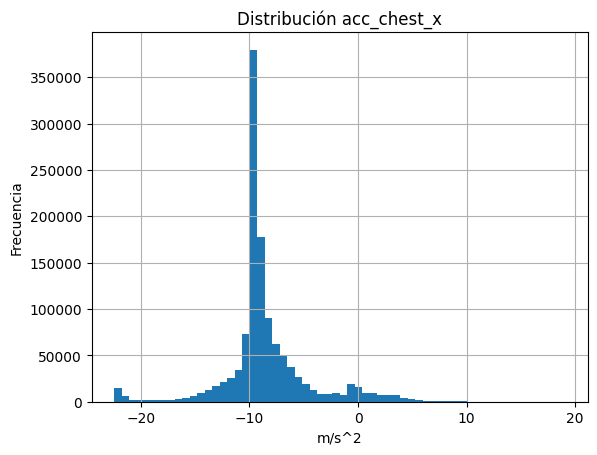

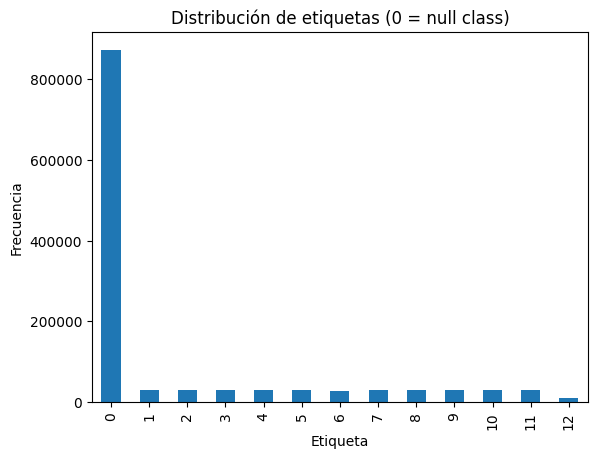

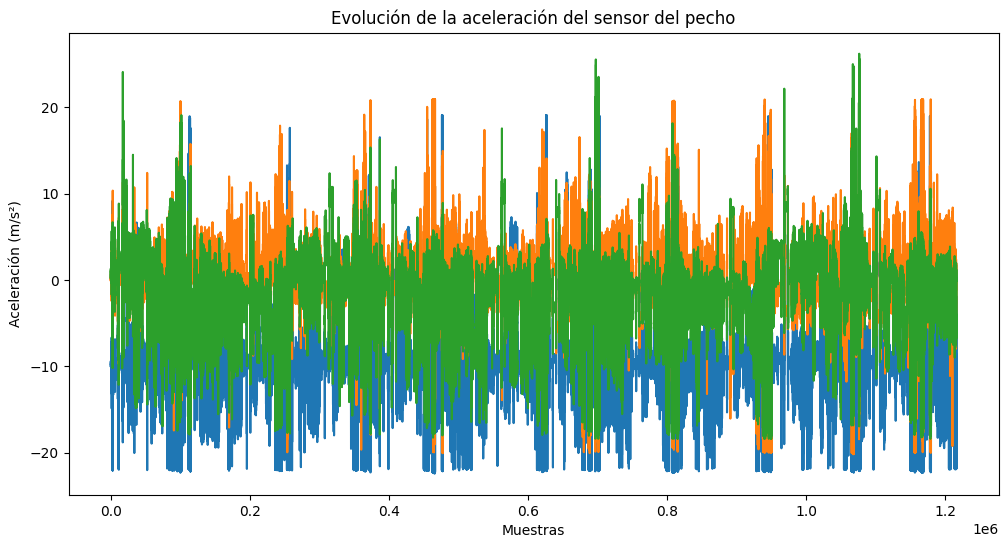

In [7]:
#Esto muestra el tipo de cada columna en el DataFrame (int64, float64, object, etc.)
print("\n=== Tipos de datos ===")
print(df.dtypes)

#Cuenta cuántos valores faltan (NaN) por columna, ordena de mayor a menor y muestra las 10 columnas con más valores faltantes.
print("\n=== Valores faltantes (top 10) ===")
print(df.isna().sum().sort_values(ascending=False).head(10))

#Aqui mostramos la media, desviación estándar, min, max, percentiles para las columnas numéricas.
print("\n=== Estadísticas descriptivas (primeras columnas) ===")
print(df.describe().T.head(10))

#Esto cuenta cuántos registros tiene cada etiqueta.
print("\n=== Distribución de la etiqueta (label) ===")
print(df["label"].value_counts().sort_index())

#Visualizaciones iniciales
try:
    #Histograma de una señal ejemplo (aceleración pecho X)
    #Esto sirve para ver cómo se distribuyen los valores de esa variable (¿normal? ¿asimétrica? ¿hay valores atipicos?).
    plt.figure()
    df["acc_chest_x"].hist(bins=60)
    plt.title("Distribución acc_chest_x")
    plt.xlabel("m/s^2")
    plt.ylabel("Frecuencia")
    plt.show()

    #Conteo de clases
    #Se muestra visualmente si hay clases con muchas o pocas muestras.
    plt.figure()
    df["label"].value_counts().sort_index().plot(kind="bar")
    plt.title("Distribución de etiquetas (0 = null class)")
    plt.xlabel("Etiqueta")
    plt.ylabel("Frecuencia")
    plt.show()

    # Graficar la aceleración en los tres ejes del sensor del pecho
    plt.figure(figsize=(12, 6))
    plt.plot(df['acc_chest_x'], label='Aceleración X')
    plt.plot(df['acc_chest_y'], label='Aceleración Y')
    plt.plot(df['acc_chest_z'], label='Aceleración Z')
    plt.title('Evolución de la aceleración del sensor del pecho')
    plt.xlabel('Muestras')
    plt.ylabel('Aceleración (m/s²)')
    plt.show()
except Exception as _:
    pass

## Limpieza inicial de los datos

### Eliminación de duplicados
Se eliminaron filas duplicadas exactas del dataset para evitar que las observaciones repetidas afecten los análisis posteriores.  
Esto asegura que cada fila corresponda a una medición única.

### Manejo de valores nulos
- **Señales numéricas**: si existen valores faltantes, se imputan mediante interpolación lineal.  
  Esto es apropiado porque las señales fisiológicas son series temporales continuas y se pueden estimar entre valores vecinos.
- **Etiqueta (`label`)**: si contiene nulos, se reemplazan con la moda.  
  Esta estrategia es simple pero razonable cuando la cantidad de valores faltantes es baja.

Después de este proceso, se verifica que no queden valores nulos en el dataset.

### Manejo de valores atípicos
Se implementa una técnica de **winsorización basada en el rango intercuartílico:
- Se calculan los límites inferior y superior permitidos para cada variable.  
- Los valores fuera de rango se recortan a esos límites.  
- Se utilizó un factor `k=3.0`, más permisivo que el estándar (`1.5`), ya que los datos fisiológicos suelen tener variaciones amplias que no necesariamente representan errores.

Con este paso, se atenúan los valos atipicos extremos sin eliminar información valiosa.


In [ ]:
#Eliminar duplicados exactos (si los hubiera)
before = len(df)                      # número de filas antes de limpiar
df = df.drop_duplicates()             # elimina filas duplicadas exactas
after = len(df)                       # número de filas después de limpiar
print(f"\nDuplicados eliminados: {before - after}")  # muestra cuántos se eliminaron

#Manejo de valores nulos
#Separamos columnas de señales (todos menos 'label' y 'subject_id')
signals_cols = [c for c in df.columns if c not in ("label", "subject_id")]

#Para señales numéricas:
#Si hay valores faltantes, se imputan mediante interpolación lineal
if df[signals_cols].isna().sum().sum() > 0:
    df[signals_cols] = df[signals_cols].interpolate(method="linear", limit_direction="both")

#Para la columna 'label':
#Si existen nulos, se reemplazan por la moda (el valor más frecuente)
if df["label"].isna().any():
    moda_label = df["label"].mode().iloc[0]
    df["label"] = df["label"].fillna(moda_label)

print("\nNulos restantes (total):", int(df.isna().sum().sum()))  #total de nulos después de la limpieza

#Detección y atenuación de valores atípicos mediante winsorización por IQR
def winsorize_iqr(s, k=1.5):
    #Calcula el rango intercuartílico
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    #Límites inferior y superior permitidos
    low = q1 - k * iqr
    high = q3 + k * iqr
    #Recorta (clip) los valores fuera del rango
    return s.clip(lower=low, upper=high)

#Aplicamos winsorización a todas las columnas de señales
df_w = df.copy()
for c in signals_cols:
    df_w[c] = winsorize_iqr(df_w[c], k=3.0)  # k=3 es más permisivo, útil para series fisiológicas



Duplicados eliminados: 0

Nulos restantes (total): 0


## Estandarización

Se aplicó **StandardScaler** a todas las columnas de señales para que tengan media = 0 y desviación estándar = 1.  
Esto es opcional, pero útil para modelos de machine learning sensibles a la escala de los datos (por ejemplo SVM, KNN o redes neuronales).  
No se escalaron las columnas `label` ni `subject_id`.

## Guardado de resultados

- `mhealth_raw.csv`: Dataset concatenado sin limpieza.  
- `mhealth_clean.csv`: Dataset limpio, winsorizado y estandarizado.  

Se guardan en formato CSV para facilitar el análisis posterior.

In [ ]:
#Estandarización
df_scaled = df_w.copy()              # Creamos una copia del DataFrame ya limpiado y winsorizado
scaler = StandardScaler()            # Inicializamos el escalador de sklearn
# Aplicamos estandarización (media=0, desviación estándar=1) solo a las columnas de señales
df_scaled[signals_cols] = scaler.fit_transform(df_scaled[signals_cols])

#Guardar resultados
RAW_CSV = "mhealth_raw.csv"          # Nombre del CSV con datos concatenados sin limpiar
CLEAN_CSV = "mhealth_clean.csv"      # Nombre del CSV con datos limpios, winsorizados y estandarizados

#Guardar DataFrames en archivos CSV
df.to_csv(RAW_CSV, index=False)
df_scaled.to_csv(CLEAN_CSV, index=False)

print(f"\nGuardado: {RAW_CSV} (raw concatenado)")
print(f"Guardado: {CLEAN_CSV} (limpio + winsor + estandarizado)")




Guardado: mhealth_raw.csv (raw concatenado)
Guardado: mhealth_clean.csv (limpio + winsor + estandarizado)
